In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.quantum_info import Operator

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Bitstream Vera Sans",
#    "font.sans-serif": "Helvetica",
})

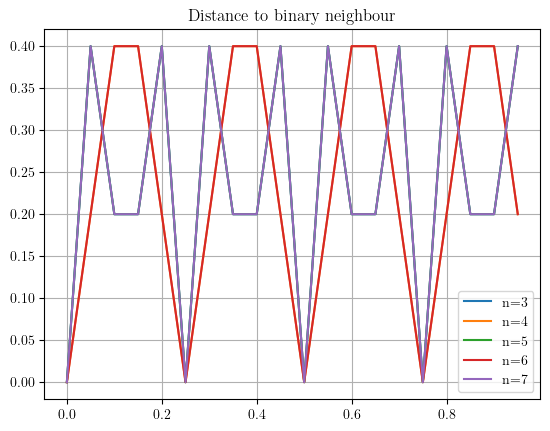

In [2]:
a = [i/20 for i in range(20)]

def dist(a: list, t: int):
    binaries = [i*2**(-t) for i in range(2**t+1)]
    distance = []
    for i in a:
        distance.append(1)
        for j in binaries:
            if np.abs(i-j) < distance[a.index(i)]:
                distance[a.index(i)] = np.abs(i-j)
        distance[a.index(i)] = distance[a.index(i)]/(2**(-t))
    return distance

hmm3 = dist(a, 3)
hmm4 = dist(a, 4)
hmm5 = dist(a, 5)
hmm6 = dist(a, 6)
hmm7 = dist(a, 7)



plt.plot(a, hmm3, label="n=3")
plt.plot(a, hmm4, label="n=4")
plt.plot(a, hmm5, label="n=5")
plt.plot(a, hmm6, label="n=6")
plt.plot(a, hmm7, label="n=7")
plt.legend()
plt.grid()
plt.title("Distance to binary neighbour")
plt.show()

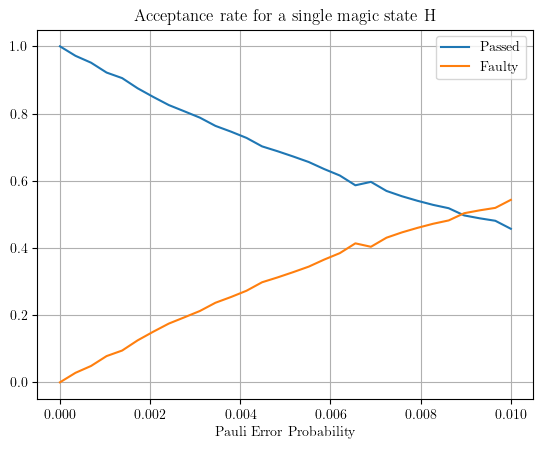

In [3]:
def magicH():  
    qc = QuantumCircuit(7+2,)
    state_inj = ClassicalRegister(14)
    qc.add_register(state_inj)

    anc = qc.num_qubits - 1
    ancc = anc - 1

    for i in range(9):                        #start noise
        qc.id(i)

    qc.h(0)
    qc.h(1)
    qc.ry(np.pi/4,2)
    qc.h(3)

    qc.cx(2,4)
    qc.cx(0,6)

    qc.cx(3,5)

    qc.cx(2,5)

    qc.cx(0,4)
    qc.cx(1,6)

    qc.cx(0,2)

    qc.cx(1,5)

    qc.cx(1,2)
    qc.cx(3,4)
    qc.cx(3,6)
    #################################Controlled Hadamards##########################################
    qc.h(ancc)
    for i in range(7):
        #qc.ch(anc-1,6-i+2*7)
        qc.ry(-np.pi/4,6-i)
        qc.cz(ancc,6-i)
        qc.ry(np.pi/4,6-i)
        if i == 0:
            qc.cx(ancc,anc)
        if i == 5:
            qc.cx(ancc,anc)
    qc.h(ancc)
    qc.measure(ancc, state_inj[0])
    qc.measure(anc, state_inj[1])
    ##########################################QEC Block#######################################
    qc.reset(anc), qc.reset(ancc)
    ##################################Z-Stabilizers##########################################
    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(0, anc)
    qc.cx(2, anc)
    qc.cx(4, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[2]), qc.measure(ancc, state_inj[8])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(ancc, anc)
    qc.cx(1, anc)
    qc.cx(2, anc)
    qc.cx(ancc, anc)
    qc.cx(5, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[3]), qc.measure(ancc, state_inj[9])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(ancc)
    qc.cx(ancc, anc)
    qc.cx(3, anc)
    qc.cx(4, anc)
    qc.cx(ancc, anc)
    qc.cx(5, anc)
    qc.cx(6, anc)
    qc.h(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[4]), qc.measure(ancc, state_inj[10])
    qc.reset(anc), qc.reset(ancc)
    ##################################X-Stabilizers##############################################
    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, 0)
    qc.cx(anc, 2)
    qc.cx(anc, 4)
    qc.cx(anc, 6)
    qc.h(anc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[5]), qc.measure(ancc, state_inj[11])
    qc.reset(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, ancc)
    qc.cx(anc, 1)
    qc.cx(anc, 2)
    qc.cx(anc, ancc)
    qc.cx(anc, 5)
    qc.cx(anc, 6)
    qc.h(anc), qc.reset(ancc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[6]), qc.measure(ancc, state_inj[12])
    qc.reset(anc)

    qc.id(anc), qc.id(ancc)
    qc.h(anc)
    qc.cx(anc, ancc)
    qc.cx(anc, 3)
    qc.cx(anc, 4)
    qc.cx(anc, ancc)
    qc.cx(anc, 5)
    qc.cx(anc, 6)
    qc.h(anc)

    qc.id(anc), qc.id(ancc)
    qc.measure(anc, state_inj[7]), qc.measure(ancc, state_inj[13])
    return qc

def testreadout(qc: QuantumCircuit, shots: int, noise: float):
    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "id", "ry"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx',"cz"])  # Apply to 2-qubit gates
    
    sim = AerSimulator()
    job = sim.run(qc, shots=shots, noise_model=noise_model)
    result = job.result()
    counts = result.get_counts()

    bits = list(counts.keys())
    hmm = list(counts.values())

    nah, valid = 0,0

    for i in range(len(bits)):
        if bits[i].count("1") != 0:
            bits[i] = "nope"
            nah += hmm[i]
        else:
            valid += hmm[i]
    
    nah = nah/shots
    valid = valid/shots

    return valid, nah

qc = magicH()

y,z = [],[]

x = np.linspace(0,0.01,30)
for i in x:
    qc = magicH()
    yes, ney = testreadout(qc, 10000, i)
    y.append(yes), z.append(ney)

plt.plot(x,y,label="Passed")
plt.plot(x,z,label="Faulty")
plt.xlabel("Pauli Error Probability")
plt.grid()
plt.title("Acceptance rate for a single magic state H")
plt.legend()
plt.show()

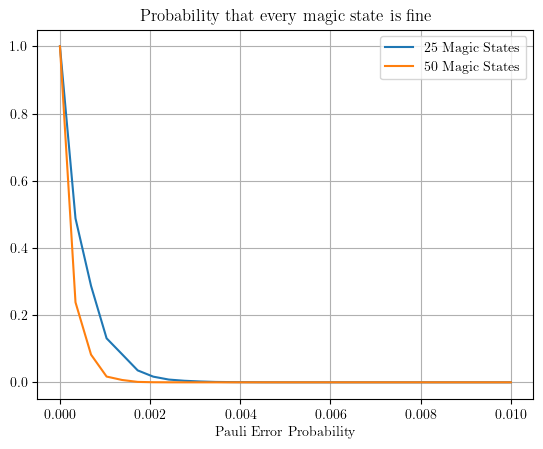

In [4]:
y25 = [i**25 for i in y]

y50 = [i**50 for i in y]

plt.plot(x,y25,label="25 Magic States")
plt.plot(x,y50,label="50 Magic States")
plt.grid()
plt.xlabel("Pauli Error Probability")
plt.legend()
plt.title("Probability that every magic state is fine")
plt.show()

In [ ]:
#erste iteration mit 0.3, ideal case ohne noise

def U2(qc: QuantumCircuit, pos: int):
    gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'sdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't']
    #gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg']
    for i in gate:
        if i == "s":
            qc.s(pos)
        if i == "sdg":
            qc.sdg(pos)
        if i == "t":
            qc.t(pos)
        if i == "tdg":
            qc.tdg(pos)
        if i == "h":
            qc.h(pos)

def adjU2(qc: QuantumCircuit, pos: int):
    gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'sdg', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 's', 'h', 's', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't']
    #gate = ['s', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'sdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h', 'tdg']
    gate.reverse()
    for i in gate:
        if i == "sdg":
            qc.s(pos)
        if i == "s":
            qc.sdg(pos)
        if i == "t":
            qc.tdg(pos)
        if i == "tdg":
            qc.t(pos)
        if i == "h":
            qc.h(pos)

def CU_L(qc: QuantumCircuit):
    U2(qc, 0)
    U2(qc, 1)
    qc.cx(0,1)
    adjU2(qc, 1)
    qc.cx(0,1)

    # qc.rz(2*np.pi*0.15,0)
    # qc.rz(2*np.pi*0.15,1)
    # qc.cx(0,1)
    # qc.rz(-2*np.pi*0.15,1)
    # qc.cx(0,1)

qr = QuantumRegister(2,"q")
cbit = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbit)

qc.x(1)
qc.h(0)

for i in range(1):
    CU_L(qc)

qc.sdg(0)
# qc.tdg(0)
#qc.z(0)
#qc.rz(-np.pi/8,0)

qc.h(0)

qc.measure(0,0)

shots = 100000

sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

hits = list(counts.values())
bit = list(counts.keys())

one = 0
for i in range(len(bit)):
    if bit[i] == "0":
        one += hits[i]

print(counts)

print("Succesrate: ", one/shots)

{'1': 3173, '0': 96827}
Succesrate:  0.96827


In [ ]:
def randomU(n: int):
    u, adju = [],[]
    degah = np.linspace(0,1,n+2)
    degah = np.delete(degah, [n+1])
    degah = np.delete(degah, [0])
    print(degah)
    for k in degah:
        qc = QuantumCircuit(1)
        qc.rz(2*np.pi*(k/2), 0)
        skd = SolovayKitaev(recursion_degree=1)
        discretized = skd(qc)

        hmm = discretized.data
        h = 0
        t = 0
        decomp = []

        for instruction in hmm:
            if instruction.name == "h":
                h+=1
                decomp.append("h")
            if instruction.name == "t":
                t+=1
                decomp.append("t")
            if instruction.name == "tdg":
                t+=1
                decomp.append("tdg")


        for i in range(len(decomp)-1):
            if decomp[i] == decomp[i+1]:
                if decomp[i] == "t":
                    decomp[i+1] = "s"
                    decomp [i] = 0
                if decomp[i] == "tdg":
                    decomp[i+1] ="sdg"
                    decomp [i] = 0
        try:
            decomp.remove(0)
        except ValueError:
            True

        decomp = [i for i in decomp if i != 0]

        for i in range(len(decomp)-1):
            if decomp[i] == decomp[i+1]:
                if decomp[i] == "s":
                    decomp[i+1] = "z"
                    decomp [i] = 0
                if decomp[i] == "sdg":
                    decomp[i+1] ="z"
                    decomp [i] = 0
        try:
            decomp.remove(0)
        except ValueError:
            True

        decomp = [i for i in decomp if i != 0]

        nah = decomp.copy()
        u.append(nah)
        decomp.reverse()
        for i in range(len(decomp)):
            if decomp[i] == "t":
                decomp[i] = "tdg"
                continue
            if decomp[i] == "tdg":
                decomp[i] = "t"
                continue
            if decomp[i] == "s":
                decomp[i] = "sdg"
                continue
            if decomp[i] == "sdg":
                decomp[i] = "s"
                continue
        # print("U nachher: ",u)
        adju.append(decomp)

    with open("Unitary/unitary{}.txt".format(n), "w") as file:
        for i in u:
            file.write(",".join(map(str, i)) + "\n")

    with open("Unitary/adjunitary{}.txt".format(n), "w") as file:
        for i in adju:
            file.write(",".join(map(str, i)) + "\n")

randomU(2)


[0.33333333 0.66666667]


In [11]:
a, b = [], []
with open("unitary10.txt", "r") as file:
    for line in file:
        a.append(list(map(str, line.strip().split(","))))
with open("adjunitary10.txt", "r") as file:
    for line in file:
        b.append(list(map(str, line.strip().split(","))))

print(len(a[1]))

33


In [12]:
#erste iteration mit 0.3, ideal case ohne noise

def U2(qc: QuantumCircuit, pos: int, gate: list):
    for i in gate:
        if i == "s":
            qc.s(pos)
        if i == "sdg":
            qc.sdg(pos)
        if i == "t":
            qc.t(pos)
        if i == "tdg":
            qc.tdg(pos)
        if i == "h":
            qc.h(pos)
        if i == "z":
            qc.z(pos)

def CU_L(qc: QuantumCircuit, Ugates: list, adjUgates: list):
    U2(qc, 0, Ugates)
    U2(qc, 1, Ugates)
    qc.cx(0,1)
    U2(qc, 1, adjUgates)
    qc.cx(0,1)

    # qc.rz(2*np.pi*0.15,0)
    # qc.rz(2*np.pi*0.15,1)
    # qc.cx(0,1)
    # qc.rz(-2*np.pi*0.15,1)
    # qc.cx(0,1)

angles = np.linspace(0,1,100)
angles = np.delete(angles, [100-1])
angles = np.delete(angles, [0])

qr = QuantumRegister(2,"q")
cbit = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbit)

qc.x(1)
qc.h(0)

for i in range(4):
    CU_L(qc, a, b)

#qc.sdg(0)
#qc.tdg(0)
#qc.z(0)
#qc.rz(-np.pi/8,0)

qc.h(0)

qc.measure(0,0)

shots = 10

sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()

hits = list(counts.values())
bit = list(counts.keys())

one = 0
for i in range(len(bit)):
    if bit[i] == "0":
        one += hits[i]

print(counts)

print("Succesrate: ", one/shots)

{'0': 10}
Succesrate:  1.0


In [2]:
def convert(bin: str):                  #konvertiert den bitstring in decimal, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def U2(qc: QuantumCircuit, pos: int, gate: list):
    for i in gate:
        if i == "s":
            qc.s(pos)
        if i == "sdg":
            qc.sdg(pos)
        if i == "t":
            qc.t(pos)
        if i == "tdg":
            qc.tdg(pos)
        if i == "h":
            qc.h(pos)
        if i == "z":
            qc.z(pos)

def CU_L(qc: QuantumCircuit, Ugates: list, adjUgates: list):
    U2(qc, 0, Ugates)
    U2(qc, 1, Ugates)
    qc.cx(0,1)
    U2(qc, 1, adjUgates)
    qc.cx(0,1)

def Leon(iter: int, n:int, noise: float, k = 1):       #each iteration own circuit
    angle = np.linspace(0,1,n+2)
    angle = np.delete(angle, [n+1])
    angle = np.delete(angle, [0])

    a, b = [], []
    with open("Unitary/unitary{}.txt".format(n), "r") as file:
        for line in file:
            a.append(list(map(str, line.strip().split(","))))
    with open("Unitary/adjunitary{}.txt".format(n), "r") as file:
        for line in file:
            b.append(list(map(str, line.strip().split(","))))
    
    y = 0
    bruh1 = []
    for m in range(k):
        for o in range(n):
            bitstring = ""
            rots = []
            for i in range(iter):
                rots = [k*0.5 for k in rots]
                qr = QuantumRegister(2,"q")
                cbit = ClassicalRegister(1, "c")
                qc = QuantumCircuit(qr, cbit)

                p = noise
                p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
                p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])
                noise_model = NoiseModel()
                noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "t", "tdg", "rz"])  # Apply to single-qubit gates
                noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates
                
                qc.x(1)
                qc.h(0)
                for j in range(2**(iter-i-1)):
                    CU_L(qc, a[o], b[o])

                for l in rots:
                    qc.rz(-2*np.pi*l,0)

                qc.h(0)
                qc.measure(0,0)

                sim = AerSimulator()
                job = sim.run(qc, shots=1, noise_model=noise_model)
                result = job.result()
                counts = result.get_counts()
                bit = list(counts.keys())   

                if bit[0] == "0":
                    bitstring += "0"
                else:
                    bitstring += "1"
                    rots.append(0.5)
            bitstring = bitstring[::-1]
            hmm = convert(bitstring)
            diff = np.abs(hmm-angle[o])
            y += diff
            bruh1.append(diff)
    y = y/(n*k)

    arg = 0
    for i in range(len(bruh1)):
        arg += (y-bruh1[i])**2
    sigma = ((1/(k*n))*arg)**0.5
    sigma = sigma/((k*n)**0.5)

    return y, sigma

def Dustin(iter: int, n:int, noise: float, k = 1):      #3 iterations in one circuit
    angle = np.linspace(0,1,n+2)
    angle = np.delete(angle, [n+1])
    angle = np.delete(angle, [0])

    a, b = [], []
    with open("Unitary/unitary{}.txt".format(n), "r") as file:
        for line in file:
            a.append(list(map(str, line.strip().split(","))))
    with open("Unitary/adjunitary{}.txt".format(n), "r") as file:
        for line in file:
            b.append(list(map(str, line.strip().split(","))))
    
    y = 0
    bruh1,bruh2 = [],[]                 #bruh1 precicions, bruh2 how often did bruh 1 occur
    for o in range(n):
        qr = QuantumRegister(2,"q")
        cbit = ClassicalRegister(iter, "c")
        qc = QuantumCircuit(qr, cbit)

        p = noise
        p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
        p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "s", "sdg", "t", "tdg", "rz"])  # Apply to single-qubit gates
        noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

        for i in range(iter):
            qc.reset(0), qc.reset(1)
            qc.x(1)
            qc.h(0)
            for j in range(2**(iter-i-1)):
                CU_L(qc, a[o], b[o])

            for l in range(i):
                with qc.if_test((l,1)):
                    qc.rz(-2*np.pi*(2**(-i+l-1)),0)

            qc.h(0)
            qc.measure(0,i)
            
        shots = k
        sim = AerSimulator()
        job = sim.run(qc, shots=shots, noise_model=noise_model)
        result = job.result()
        counts = result.get_counts()
        bits = list(counts.keys())   
        value = list(counts.values())
        
        for i in range(len(bits)):
            hmm = convert(bits[i])
            diff = np.abs(hmm-angle[o])
            y += diff*value[i]
            bruh1.append(diff), bruh2.append(value[i])
    y = y/(n*k)
    #calculate err####################
    arg = 0
    for i in range(len(bruh1)):
        arg += ((y-bruh1[i])**2)*bruh2[i]
    sigma = ((1/(k*n))*arg)**0.5
    sigma = sigma/((k*n)**0.5)
    ###################################
    return y, sigma

In [32]:
x = [i for i in range(10)]

ehm =  []

for i in range(10):
    while True:
        if i < 5:
            print(i)
            ehm.append(1)
            break
        else:
            break

print(ehm)

0
1
2
3
4
[1, 1, 1, 1, 1]


In [14]:
p = np.linspace(0,0.5,10)

y_all, y_all1 = [],[]
err, err1 = [], []

for i in p:
    ok, errr = Leon(3, 2, i, k=100)
    ok1, errr1 = Dustin(3, 2, i, k=100)
    y_all.append(ok), err.append(errr)
    y_all1.append(ok1), err1.append(errr1)

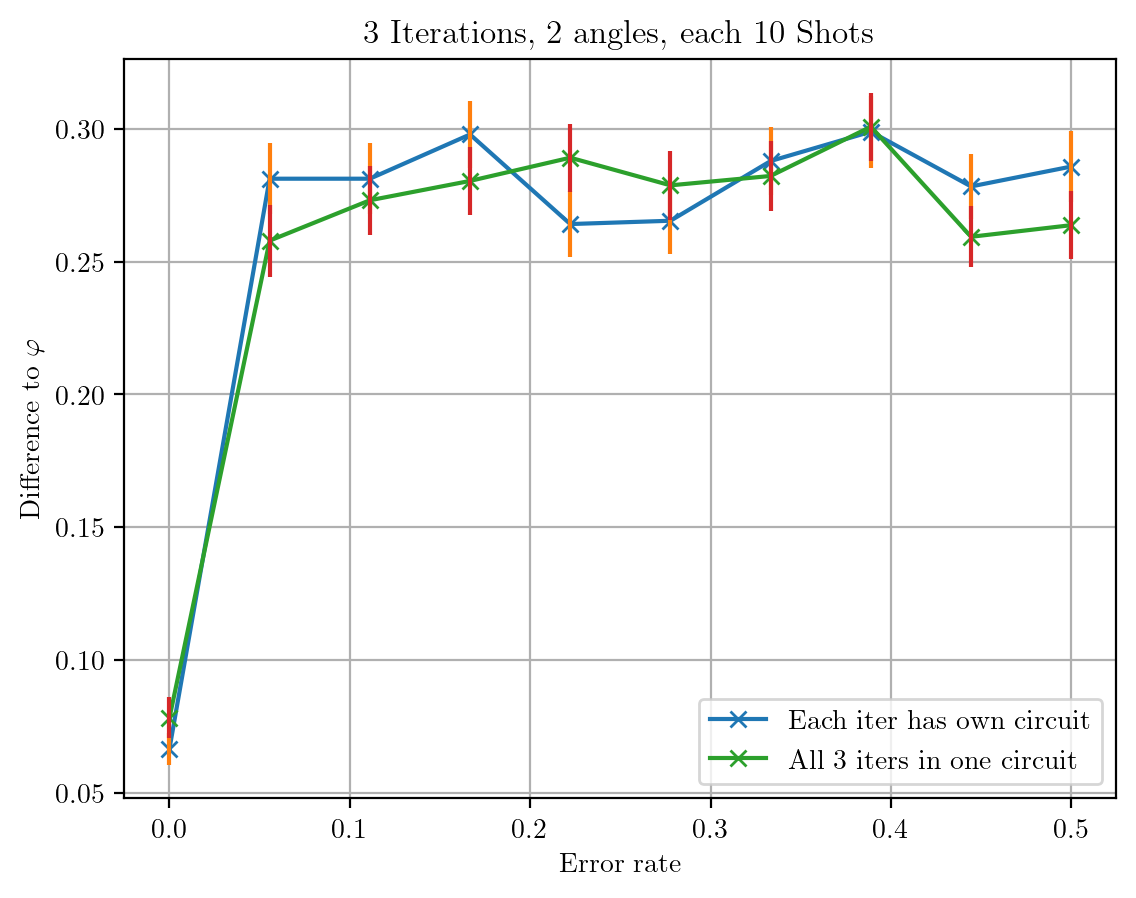

y_all:  [0.06645833333333324, 0.28124999999999983, 0.2812499999999998, 0.2979166666666663, 0.26416666666666644, 0.2654166666666665, 0.2879166666666664, 0.298958333333333, 0.278333333333333, 0.28583333333333316]
y_err:  [0.005929984278365898, 0.013322749705756018, 0.01336178604786384, 0.012780702412882747, 0.012494582159213393, 0.012704268475595125, 0.012816107215791643, 0.01349008605884335, 0.012150531538441712, 0.013264928696880856]


In [15]:
plt.figure(dpi=200)
plt.plot(p, y_all, marker="x",label="Each iter has own circuit")
plt.errorbar(p,y_all,yerr=err,linestyle="")

plt.plot(p, y_all1, marker="x",label="All 3 iters in one circuit")
plt.errorbar(p,y_all1,yerr=err1,linestyle="")

plt.xlabel("Error rate")
plt.ylabel(r"Difference to $\varphi$")
plt.title("3 Iterations, 2 angles, each 10 Shots")
plt.grid()
plt.legend()
plt.show()

print("y_all: ", y_all)
print("y_err: ", err)

In [36]:
p = np.linspace(0,0.05,5)

y_all, y_all1, y_all2, y_all3, y_all4 = [],[],[],[],[]

yerr1, yerr2, yerr3, yerr4 = [],[],[],[]

for i in p:
    ok1, err1 = Dustin(3,30,i,k=30)
    ok2, err2 = Dustin(3,50,i,k=30)
    ok3, err3 = Dustin(3,100,i,k=30)
    ok4, err4 = Dustin(3,500,i,k=30)
    y_all1.append(ok1), y_all2.append(ok2), y_all3.append(ok3), y_all4.append(ok4)
    yerr1.append(err1), yerr2.append(err2), yerr3.append(err3), yerr4.append(err4)

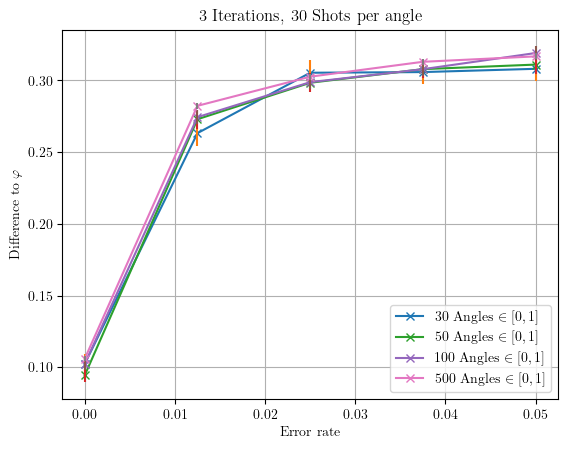

In [39]:
# plt.figure(dpi=200)
plt.plot(p, y_all1, marker="x",label="30 Angles $\in [0,1]$")
plt.errorbar(p,y_all1,yerr=yerr1,linestyle="")

plt.plot(p, y_all2, marker="x",label="50 Angles $\in [0,1]$")
plt.errorbar(p,y_all2,yerr=yerr2,linestyle="")

plt.plot(p, y_all3, marker="x",label="100 Angles $\in [0,1]$")
plt.errorbar(p,y_all3,yerr=yerr3,linestyle="")

plt.plot(p, y_all4, marker="x",label="500 Angles $\in [0,1]$")
plt.errorbar(p,y_all4,yerr=yerr4,linestyle="")

plt.xlabel("Error rate")
plt.ylabel(r"Difference to $\varphi$")
plt.title("3 Iterations, 30 Shots per angle")
plt.grid()
plt.legend()
plt.savefig("ForLeon.png", dpi = 200)
plt.show()

{'0': 54, '1': 46}


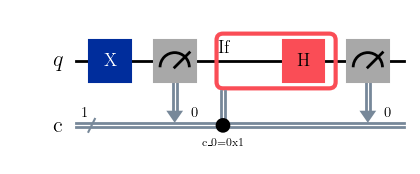

In [230]:
def test(qc: QuantumCircuit):
    k = 2
    if k == 2:
        qc.h(0)

qr = QuantumRegister(1,"q")
cbit = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cbit)
p = 5
qc.x(0)
qc.measure(0,0)
with qc.if_test((0,1)):
    if p == 5:
        test(qc)

qc.measure(0,0)

shots = 100
sim = AerSimulator()
job = sim.run(qc, shots=shots)
result = job.result()
counts = result.get_counts()
print(counts)
qc.draw("mpl")

In [209]:
i = 1

qc = QuantumCircuit(1)

qc.rz(2*np.pi*(i/2), 0)
        
skd = SolovayKitaev(recursion_degree=1)

discretized = skd(qc)

print("Discretized circuit:")
print(discretized.draw())
 
print("Error:", np.linalg.norm(Operator(qc).data - Operator(discretized).data))

Discretized circuit:
global phase: 3π/2
   ┌───┐┌───┐┌───┐┌───┐
q: ┤ T ├┤ T ├┤ T ├┤ T ├
   └───┘└───┘└───┘└───┘
Error: 4.164168542091484e-16
